In [1]:
from collections import defaultdict
import csv
import sys

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);

In [135]:
import operator
import numpy as np
from osgeo import gdal, gdal_array, osr, gdalnumeric
import shapefile
try:
    import Image
    import ImageDraw
except:
    from PIL import Image, ImageDraw
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist

In [222]:
raster_path  = '/home/dilara/project2/sentinel/super_cropped.tif'
srcArray = gdal_array.LoadFile(raster_path)
srcImage = gdal.Open(raster_path)
geoTrans = srcImage.GetGeoTransform()
shp_path = '/home/dilara/project2/sentinel/buil_cropped_13_03'
#shp_path = "/home/dilara/project2/sentinel/wat_cropped_13_03"
r = shapefile.Reader("{}.shp".format(shp_path))

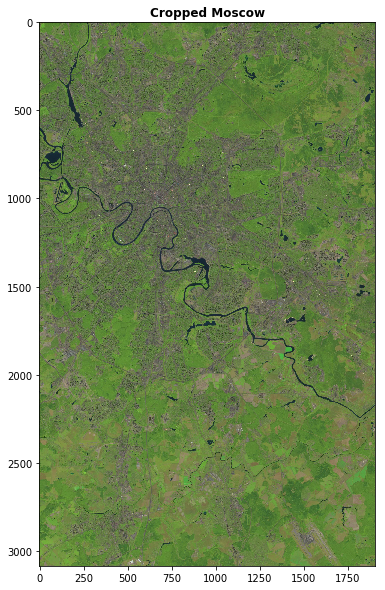

In [139]:
plt.figure(figsize=(10,10))
with rio.open(raster_path) as src:
    bb = src.read()
show(bb, title="Cropped Moscow")
plt.show()

<Figure size 1080x1080 with 0 Axes>

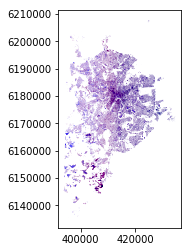

In [224]:
plt.figure(figsize=(15,15))
grid = gpd.read_file(shp_path + '.shp')
my_map = grid.plot(linewidth=0.1, cmap="Reds", scheme="quantiles", k=11, alpha=1)
grid.plot(ax=my_map, color="blue", linewidth=2.5)
plt.show()

In [163]:
g = geoTrans
g

(399960.0, 20.0, 0.0, 6200040.0, 0.0, -20.0)

In [164]:
minX, maxX, minY, maxY = g[0], (g[0] + srcImage.RasterXSize * g[1]), g[3], (g[3] + srcImage.RasterYSize * g[-1])
ulX, ulY, lrX, lrY = int(minX / g[1]), int(maxY / abs(g[-1])), int(maxX / g[1]), int(minY / abs(g[-1]))

In [165]:
pxWidth = int(lrX - ulX)
pxHeight = int(lrY - ulY)
clip = srcArray

In [166]:
geoTrans = list(geoTrans)
geoTrans[0] = minX
geoTrans[3] = maxY
geoTrans
g = geoTrans
g

[399960.0, 20.0, 0.0, 6138320.0, 0.0, -20.0]

In [225]:
pixels = []
k = len(r)
print(k)
rasterPoly = Image.new("L", (pxWidth, pxHeight), 1)
rasterize = ImageDraw.Draw(rasterPoly)
for i in range(k):
    for p in r.shape(i).points:
            a1, a2 = int((p[0] - g[0]) / g[1]), (clip.shape[1] - int((abs(p[1] - g[3])) / g[1]))
            # a1, a2 = int((p[0] - g[0]) / g[1]), (int(((p[1] - g[3])) / g[-1])) для воды
            pixels.append((a1, a2))
    rasterize.polygon(pixels, 0)
    pixels = []

print(pixels)

160305
[]


In [211]:
def imageToArray(i):
    """
    Converts a Python Imaging Library array to a gdal_array image.
    """
    a = gdal_array.numpy.frombuffer(i.tobytes(), 'b')
    a.shape = i.im.size[1], i.im.size[0]
    return a

In [226]:
mask = imageToArray(rasterPoly)
mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

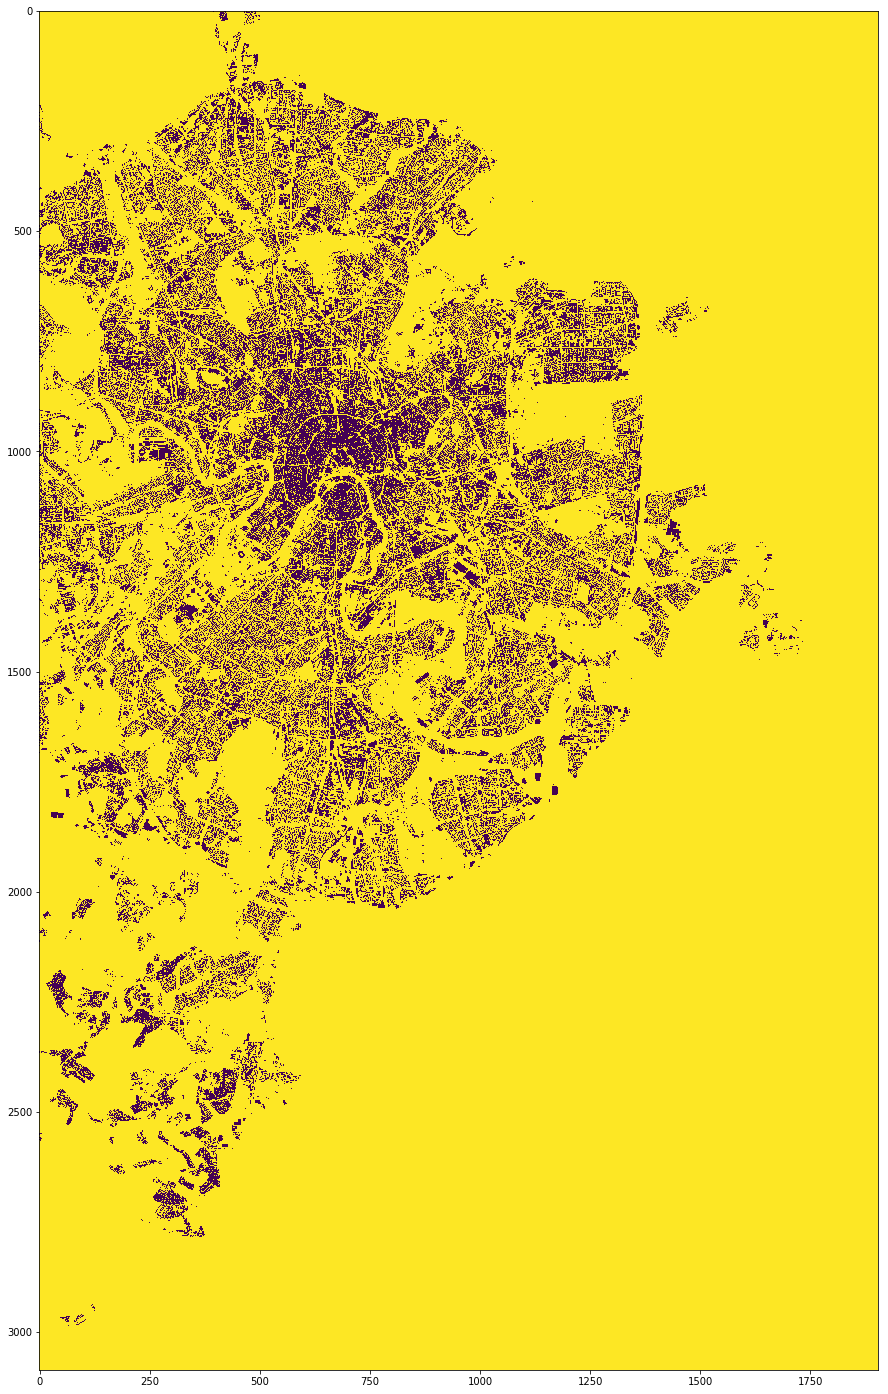

In [227]:
plt.figure(figsize=(25,25))
imshow(mask)
plt.show()

In [214]:
format = "GTiff"
driver = gdal.GetDriverByName( format )
metadata = driver.GetMetadata()
if gdal.DCAP_CREATE in metadata and metadata[ gdal.DCAP_CREATE ] == "YES":
    pass
else:
    print ("Driver %s does not support Create() method." % format)
    sys.exit( 1 )
# аналогично выполняется проверка для CreateCopy
if gdal.DCAP_CREATECOPY in metadata and metadata[ gdal.DCAP_CREATECOPY ] == "YES":
    pass
else:
    print ("Driver %s does not support CreateCopy() method." % format)
    sys.exit( 1 )

In [228]:
print(mask.shape)

(3086, 1904)


In [229]:
gtiffDriver = gdal.GetDriverByName( 'GTiff' )
dt = gdal.GDT_Byte
outClip = gtiffDriver.Create("/home/dilara/project2/sentinel/xaxa.tif", mask.shape[1], mask.shape[0], 1, dt)

In [230]:
temp2 = outClip.ReadAsArray()
print(temp2.shape, mask.shape)

(3086, 1904) (3086, 1904)


In [231]:
outClip.SetProjection(srcImage.GetProjection() )
outClip.SetGeoTransform(srcImage.GetGeoTransform())

0

In [232]:
outClip.GetRasterBand( 1 ).WriteArray( mask)

0

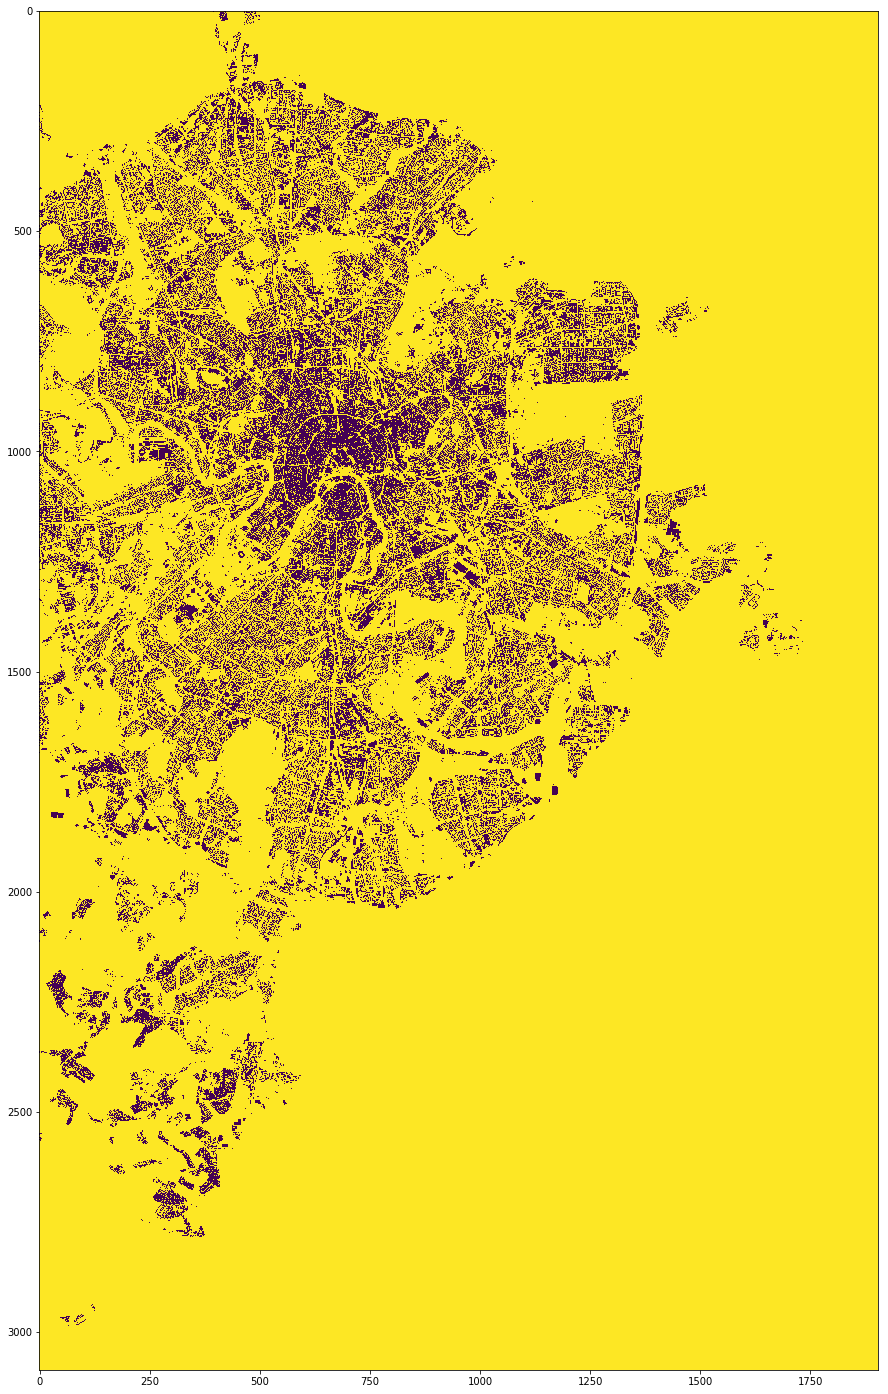

In [233]:
plt.figure(figsize=(25,25))

show(outClip.ReadAsArray())
plt.show()

In [234]:
outClip = None